In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [2]:
import os as os
os.getcwd()

'/home/ccching/EAILab-2025/EAI_Lab6/Lab6_Quantization'

In [3]:
# cd /content/drive/MyDrive/Your_Folder

#​ Block 1: Setup and Dependencies

In [4]:
# Install dependencies
#!pip install timm torch torchvision matplotlib numpy tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import timm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
from typing import Dict, List, Optional, Tuple, Union, Any
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Timm version: {timm.__version__}")


/home/ccching/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
Timm version: 0.4.12


# Block 2: Data Loading and Calibration Setup

In [5]:
# CIFAR-10 data preparation
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Create calibration subset (512 samples)
calibration_indices = np.random.choice(len(trainset), 512, replace=False)
calibration_set = Subset(trainset, calibration_indices)
calibration_loader = DataLoader(calibration_set, batch_size=32, shuffle=False)

# Test loader
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

print(f"Calibration samples: {len(calibration_set)}")
print(f"Test samples: {len(testset)}")


Calibration samples: 512
Test samples: 10000


# Block 3: Load ViT-S Model

In [6]:
# Load pretrained ViT-S model
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=10)
model = model.to(device)
model.eval()

print(f"Model: {model.__class__.__name__}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model: VisionTransformer
Total parameters: 21,669,514


# Block 4: Fine-Tuning and Baseline Evaluation (UPDATED)

FINE-TUNING ViT-S ON CIFAR-10


Epoch 1/5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 782/782 [02:09<00:00,  6.02it/s, loss=0.0679, acc=93.12%]


Epoch 1/5 - Train Loss: 0.2452, Train Acc: 93.12%, Test Acc: 97.94%, Best Acc: 97.94%


Epoch 2/5: 100%|██████████| 782/782 [02:09<00:00,  6.04it/s, loss=0.0404, acc=98.68%]


Epoch 2/5 - Train Loss: 0.0440, Train Acc: 98.68%, Test Acc: 98.15%, Best Acc: 98.15%


Epoch 3/5: 100%|██████████| 782/782 [02:09<00:00,  6.04it/s, loss=0.0015, acc=99.30%]


Epoch 3/5 - Train Loss: 0.0228, Train Acc: 99.30%, Test Acc: 98.11%, Best Acc: 98.15%


Epoch 4/5: 100%|██████████| 782/782 [02:09<00:00,  6.04it/s, loss=0.0007, acc=99.71%]


Epoch 4/5 - Train Loss: 0.0115, Train Acc: 99.71%, Test Acc: 98.45%, Best Acc: 98.45%


Epoch 5/5: 100%|██████████| 782/782 [02:09<00:00,  6.04it/s, loss=0.0008, acc=99.83%]


Epoch 5/5 - Train Loss: 0.0075, Train Acc: 99.83%, Test Acc: 98.44%, Best Acc: 98.45%

Fine-tuning completed! Best accuracy: 98.45%
Best model saved to: ./best_vit_cifar10.pth
Loaded best model from epoch 4

Evaluating fine-tuned FP32 baseline...


Evaluating: 100%|██████████| 157/157 [00:22<00:00,  7.09it/s]


FP32 Fine-tuned - Accuracy: 98.45%, Avg Latency: 0.0069s


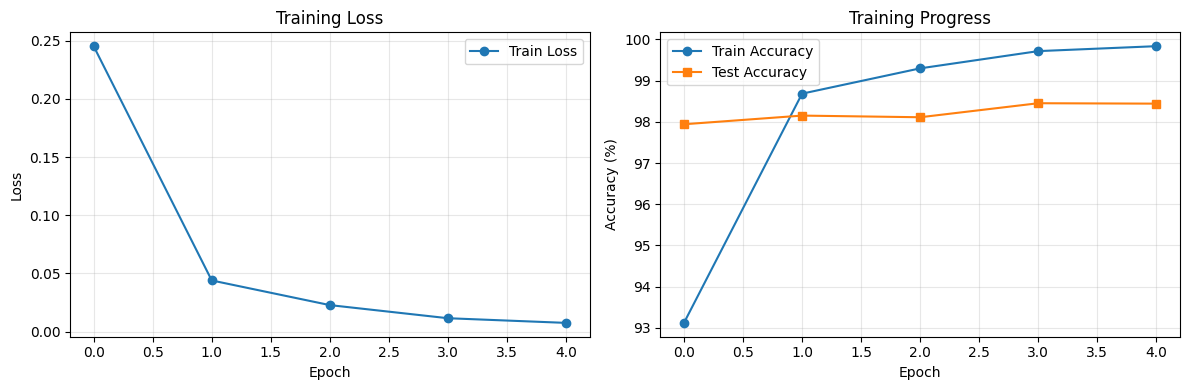

Training history plot saved to: ./training_history.png
Final model saved to: ./vit_s_cifar10_final.pth


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import os

def train_model(model, train_loader, test_loader, device, epochs=10, lr=1e-4):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    best_accuracy = 0.0
    history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total

        # Update learning rate
        scheduler.step()

        # Save best model
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': test_acc,
            }, './best_vit_cifar10.pth')

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Test Acc: {test_acc:.2f}%, "
              f"Best Acc: {best_accuracy:.2f}%")

    return model, best_accuracy, history

def evaluate_model(model, dataloader, device):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0
    inference_time = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(images)
            inference_time += time.time() - start_time

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_latency = inference_time / len(dataloader)

    return accuracy, avg_latency, inference_time

# Fine-tune the model
print("="*70)
print("FINE-TUNING ViT-S ON CIFAR-10")
print("="*70)

# Create training loader
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

############### Write here #############
# Fine-tune
fine_tuned_model, best_acc, training_history = train_model(
    model, train_loader, test_loader, device, epochs=5, lr=1e-5
)

print(f"\nFine-tuning completed! Best accuracy: {best_acc:.2f}%")
print(f"Best model saved to: ./best_vit_cifar10.pth")

# Load best model for evaluation
checkpoint = torch.load('./best_vit_cifar10.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate fine-tuned model
print("\nEvaluating fine-tuned FP32 baseline...")
fp32_accuracy, fp32_latency, fp32_time = evaluate_model(model, test_loader, device)
print(f"FP32 Fine-tuned - Accuracy: {fp32_accuracy:.2f}%, Avg Latency: {fp32_latency:.4f}s")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(training_history['test_acc'], label='Test Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to: ./training_history.png")

# Save final model with complete information
torch.save({
    'model_state_dict': model.state_dict(),
    'accuracy': fp32_accuracy,
    'model_config': {
        'name': 'vit_small_patch16_224',
        'num_classes': 10,
        'dataset': 'CIFAR-10'
    },
    'training_history': training_history
}, './vit_s_cifar10_final.pth')

print(f"Final model saved to: ./vit_s_cifar10_final.pth")

In [8]:
# Print model structure before smoothing
print("=== Structure BEFORE Smoothing ===")
print(model)


=== Structure BEFORE Smoothing ===
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((3

# Block 5: SmoothQuant Core - Activation Statistics Collection (UPDATED)

In [17]:
class ActivationCollector:

    def __init__(self) -> None:
        self.activations = {}
        self.hooks = []

    def register_hooks(self, model) -> None:
        for name, module in model.named_modules():
            # Write here
            if isinstance(module, nn.Linear): 
                hook = module.register_forward_hook(
                    self._get_hook(name)
                )
                self.hooks.append(hook)

    def _get_hook(self, name):
        def hook(modul: nn.Module, input: Tuple[torch.Tensor, ...], output:torch.Tensor):
            # Record max absolute values per input channel
            x = input[0].detach()

            if x.dim() == 3:
                x = x.reshape(-1, x.size(-1))
            elif x.dim() == 2:
                pass
            else:
                return

            channel_max = torch.abs(x).max(dim=0)[0]

            if name not in self.activations:
                self.activations[name] = channel_max
            else:
                self.activations[name] = torch.max(
                    self.activations[name], channel_max
                )
        return hook

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []


#Block 6: SmoothQuant - Compute Smoothing Factors

In [18]:
def compute_smoothing_factors(model, activation_stats, alpha=0.5):

    smoothing_factors = {}

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and name in activation_stats:

            ############## Write here ##############
            # 1. Get activation max per channel
            act = activation_stats[name]
            actMax = act.abs().amax(dim = tuple(range(act.dim() - 1)))

            # 2. Get weight max per input channel
            weight = module.weight
            weightMax = weight.abs().amax(dim=0)
            e = 1e-8
            actMax = actMax.clamp(min=e)
            weightMax = weightMax.clamp(min=e)
            # 3. Compute smoothing factor
            s = (actMax / weightMax).pow(alpha)

            smoothing_factors[name] = s.to(device)

    return smoothing_factors


#Block 7: SmoothQuant - Apply Smoothing Transformation

In [19]:
@torch.no_grad()
def smooth_ln_fcs(ln, fc, scales):

    if not isinstance(fc, nn.Linear) or not isinstance(ln, (nn.LayerNorm, nn.Embedding)):
        print(f"Warning: Skipping smoothing, layers not match: {type(ln)}, {type(fc)}")
        return

    ########### Write here ############
    # 1. Smooth the Activation Source (LayerNorm)
    if isinstance(ln, nn.LayerNorm):
        ln.weight.data.div_(scales)
        if ln.bias is not None:
            ln.bias.data.div_(scales)
    elif isinstance(ln, nn.Embedding):
        ln.weight.data.div_(scales)
    # 2. Smooth the Weight (Linear)
    fc.weight.data.mul_(scales.view(1,-1))


    # Note: Linear's bias does not need modification, because (X/s) * (W*s) + b = XW + b


In [20]:
def apply_smooth_quant_vit(model, smoothing_factors):

    print("Applying SmoothQuant fusion (LN -> Linear)...")

    blocks = model.blocks if hasattr(model, 'blocks') else model.encoder.layers

    for i, block in enumerate(blocks):

        # Process Attention's QKV (Norm1 -> QKV)
        qkv_key = f"blocks.{i}.attn.qkv"
        if qkv_key in smoothing_factors:
            scales = smoothing_factors[qkv_key]
            # Pass LayerNorm (norm1) and Linear (qkv)
            smooth_ln_fcs(block.norm1, block.attn.qkv, scales)

        # Process FC1 (Norm2 -> FC1)
        fc1_key = f"blocks.{i}.mlp.fc1"
        if fc1_key in smoothing_factors:
            scales = smoothing_factors[fc1_key]
            # Pass LayerNorm (norm2) and Linear (fc1)
            smooth_ln_fcs(block.norm2, block.mlp.fc1, scales)

        # Skip FC2
        # Because FC2 does not have LN before it

    print("Fusion complete. LayerNorms and Linear weights have been updated.")
    return model


#Block 8: Quantization Functions

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

@torch.no_grad()
def quantize_weight_per_channel(w, n_bits=8):

    ############ Write here ##############
    # 2. claculate q_max
    q_max = 2 ** (n_bits - 1) - 1
    # 1. calulate scales
    scales = w.abs().max(dim=-1,keepdim=True)[0] / q_max

    

    # 3. clamp the scales
    scales = scales.clamp(min=1e-6)

    # 4. Quantize
    t_quant = (w/scales).round().clamp(-q_max, q_max).to(torch.int8)

    # 5. Dequantize
    w_dequant = t_quant * scales

    return w_dequant

def quantize_activation_dynamic_per_token(t, n_bits=8):

    ############ Write here ##############
    # 2. claculate q_max
    q_max = 2 ** (n_bits - 1) - 1
    # 1. calulate scales
    scales = t.abs().max(dim=-1,keepdim=True)[0] / q_max

    

    # 3. clamp the scales
    scales = scales.clamp(min=1e-6)

    # 4. Quantize
    t_quant = (t/scales).round().clamp(-q_max, q_max)

    # 5. Dequantize
    t_dequant = t_quant * scales

    return t_dequant


In [27]:
class QuantizedLinear(nn.Module):
    def __init__(self, original_layer, n_bits=8):

        super().__init__()
        self.in_features = original_layer.in_features
        self.out_features = original_layer.out_features
        self.n_bits = n_bits

        # Weights are statically quantized
        with torch.no_grad():
            self.weight = nn.Parameter(
                quantize_weight_per_channel(original_layer.weight.data, n_bits),
                requires_grad=False
            )

            if original_layer.bias is not None:
                self.bias = nn.Parameter(original_layer.bias.data.clone(), requires_grad=False)
            else:
                self.register_parameter('bias', None)

    def forward(self, x):

        # Call dynamic quantization function
        x_q = quantize_activation_dynamic_per_token(x, self.n_bits)

        return F.linear(x_q, self.weight, self.bias)


In [28]:
def quantize_model_dynamic(model, n_bits=8):
    quantized_model = copy.deepcopy(model)
    for name, module in quantized_model.named_modules():
        if isinstance(module, nn.Linear):

            quant_linear = QuantizedLinear(module, n_bits=n_bits)

            parent_name = '.'.join(name.split('.')[:-1])
            child_name = name.split('.')[-1]
            if parent_name:
                parent = quantized_model.get_submodule(parent_name)
            else:
                parent = quantized_model
            setattr(parent, child_name, quant_linear)
    return quantized_model


# Block 9 : Application Place

In [29]:
print("\n" + "="*70)
print("COLLECTING ACTIVATION STATISTICS (Fine-tuned Model)")
print("="*70)
collector = ActivationCollector()
collector.register_hooks(model)

model.eval()
with torch.no_grad():
    for images, _ in tqdm(calibration_loader, desc="Calibration"):
        images = images.to(device)
        _ = model(images)

collector.remove_hooks()
activation_stats = collector.activations
print(f"Collected statistics for {len(activation_stats)} linear layers")


COLLECTING ACTIVATION STATISTICS (Fine-tuned Model)


Calibration: 100%|██████████| 16/16 [00:01<00:00, 15.23it/s]

Collected statistics for 49 linear layers


In [30]:
smoothing_factors = compute_smoothing_factors(model, activation_stats, alpha=0.5)
smoothed_model = copy.deepcopy(model)

# Smooth
print("Applying SmoothQuant Fusion...")
apply_smooth_quant_vit(smoothed_model, smoothing_factors)

# Fake Quant
print("Quantizing Model (Dynamic)...")
quantized_model = quantize_model_dynamic(smoothed_model, n_bits=8)
quantized_model = quantized_model.to(device)

print("Dynamic Quantization complete!")


Applying SmoothQuant Fusion...
Applying SmoothQuant fusion (LN -> Linear)...
Fusion complete. LayerNorms and Linear weights have been updated.
Quantizing Model (Dynamic)...
Dynamic Quantization complete!


In [31]:
print("=== Structure After Smoothing and Quantize ===")
print(quantized_model)

=== Structure After Smoothing and Quantize ===
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): QuantizedLinear()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): QuantizedLinear()
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): QuantizedLinear()
        (act): GELU(approximate='none')
        (fc2): QuantizedLinear()
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): QuantizedLinear()
        (attn_drop): Dropout(p=

# Block 9: Evaluate Quantized Model

In [33]:
print("\n" + "="*70)
print("EVALUATING QUANTIZED MODEL")
print("="*70)
quant_accuracy, quant_latency, quant_time = evaluate_model(
    quantized_model, test_loader, device
)
print(f"W8A8 SmoothQuant - Accuracy: {quant_accuracy:.2f}%, Avg Latency: {quant_latency:.4f}s")

# Save quantized model
torch.save({
    'model_state_dict': quantized_model.state_dict(),
    'smoothing_factors': smoothing_factors,
    'alpha': 0.5,
    'accuracy': quant_accuracy,
    'model_config': {
        'name': 'vit_small_patch16_224',
        'num_classes': 10,
        'dataset': 'CIFAR-10',
        'quantization': 'W8A8'
    }
}, './vit_s_quantized_cifar10.pth')
print(f"Quantized model saved to: ./vit_s_quantized_cifar10.pth")



EVALUATING QUANTIZED MODEL


Evaluating: 100%|██████████| 157/157 [00:23<00:00,  6.59it/s]


W8A8 SmoothQuant - Accuracy: 98.37%, Avg Latency: 0.0132s
Quantized model saved to: ./vit_s_quantized_cifar10.pth


# Block 10: Benchmark Results Table

In [34]:
print("\n" + "="*70)
print("BENCHMARK RESULTS - CIFAR-10 (Fine-tuned Model)")
print("="*70)
print(f"{'Method':<30} {'Accuracy (%)':<15} {'Latency (s)':<15} {'Total Time (s)':<15}")
print("-"*70)
print(f"{'FP32 Fine-tuned':<30} {fp32_accuracy:<15.2f} {fp32_latency:<15.4f} {fp32_time:<15.2f}")
print(f"{'W8A8 SmoothQuant':<30} {quant_accuracy:<15.2f} {quant_latency:<15.4f} {quant_time:<15.2f}")
print("-"*70)
print(f"{'Accuracy Delta':<30} {quant_accuracy - fp32_accuracy:<15.2f}")
print(f"{'Speedup':<30} {fp32_time / quant_time:<15.2f}x")
print("="*70)

# Calculate memory savings
fp32_size = sum(p.numel() * 4 for p in model.parameters()) / (1024**2)  # MB
int8_size = sum(p.numel() for p in quantized_model.parameters()) / (1024**2)
print(f"\nModel Size - FP32: {fp32_size:.2f} MB")
print(f"Model Size - INT8: {int8_size:.2f} MB (approx)")
print(f"Memory Reduction: {fp32_size / int8_size:.2f}x")

# Save benchmark results
benchmark_results = {
    'fp32': {'accuracy': fp32_accuracy, 'latency': fp32_latency, 'time': fp32_time},
    'w8a8_smoothquant': {'accuracy': quant_accuracy, 'latency': quant_latency, 'time': quant_time},
    'alpha': 0.5,
    'model_size_mb': {'fp32': fp32_size, 'int8': int8_size}
}

import json
with open('./benchmark_results.json', 'w') as f:
    json.dump(benchmark_results, f, indent=4)

print(f"\nBenchmark results saved to: ./benchmark_results.json")



BENCHMARK RESULTS - CIFAR-10 (Fine-tuned Model)
Method                         Accuracy (%)    Latency (s)     Total Time (s) 
----------------------------------------------------------------------
FP32 Fine-tuned                98.45           0.0069          1.09           
W8A8 SmoothQuant               98.37           0.0132          2.07           
----------------------------------------------------------------------
Accuracy Delta                 -0.08          
Speedup                        0.52           x

Model Size - FP32: 82.66 MB
Model Size - INT8: 20.67 MB (approx)
Memory Reduction: 4.00x

Benchmark results saved to: ./benchmark_results.json


# Block 11 : Comparison Graph

>>> PLOT: WEIGHT BEFORE/AFTER


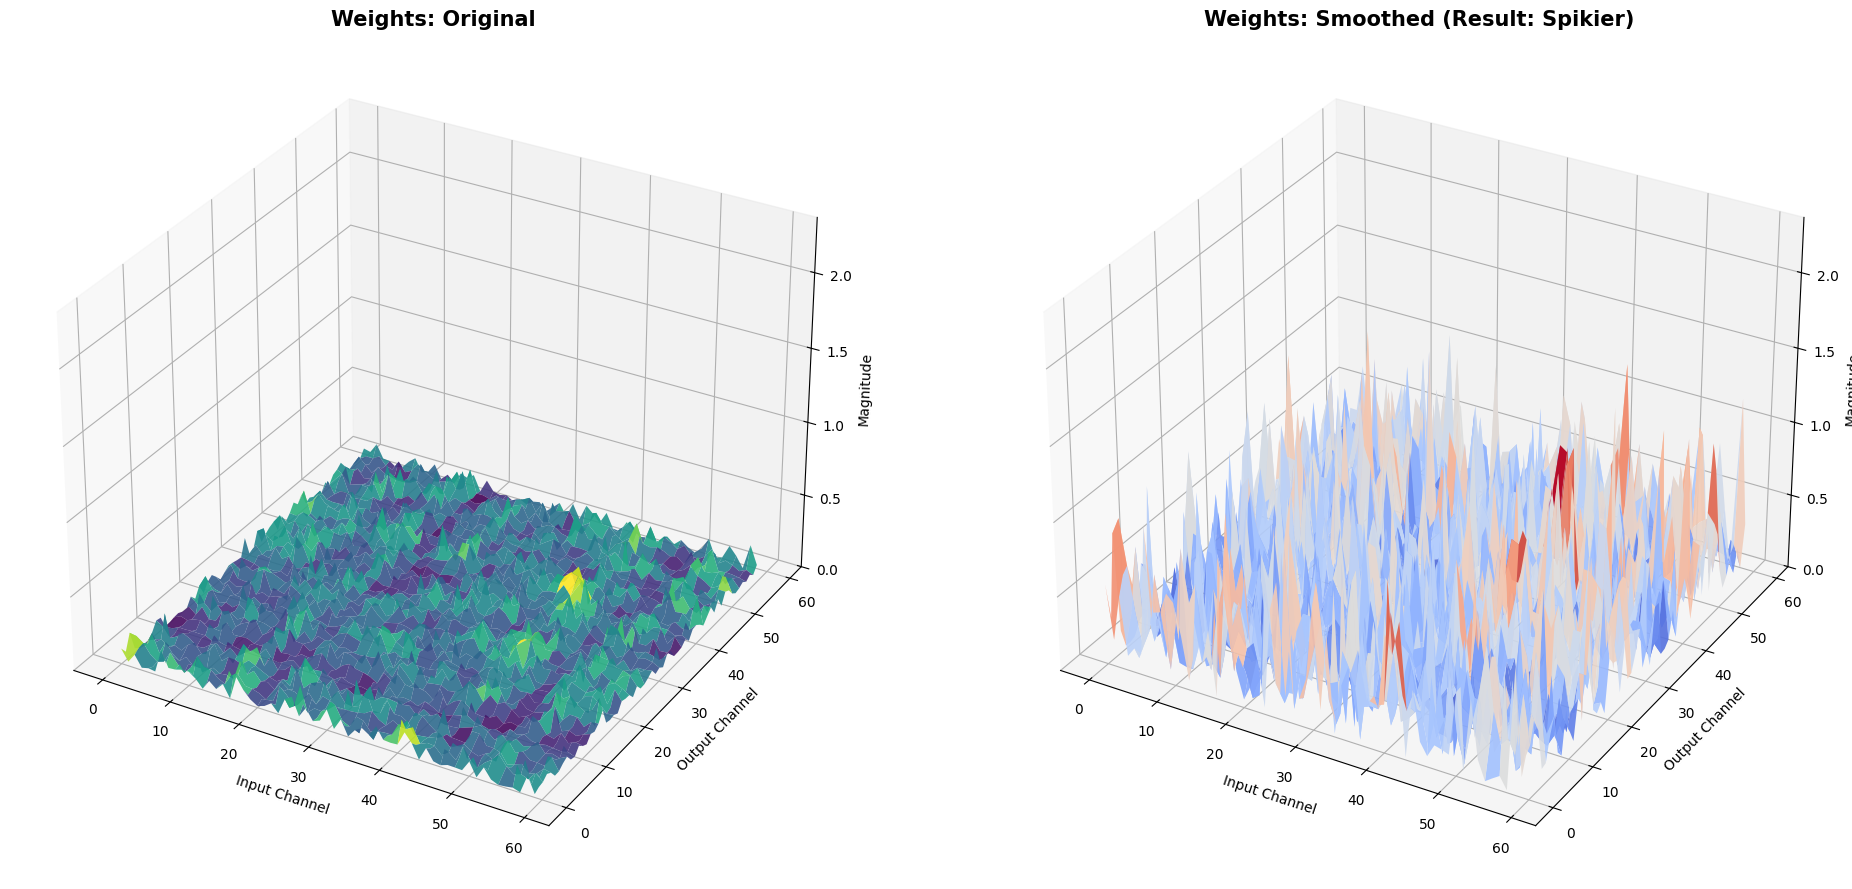


>>> PLOT: ACTIVATION BEFORE/AFTER
Activation Before Max: 6.76
Activation After Max:  1.25
(You should see the After Max is significantly smaller)


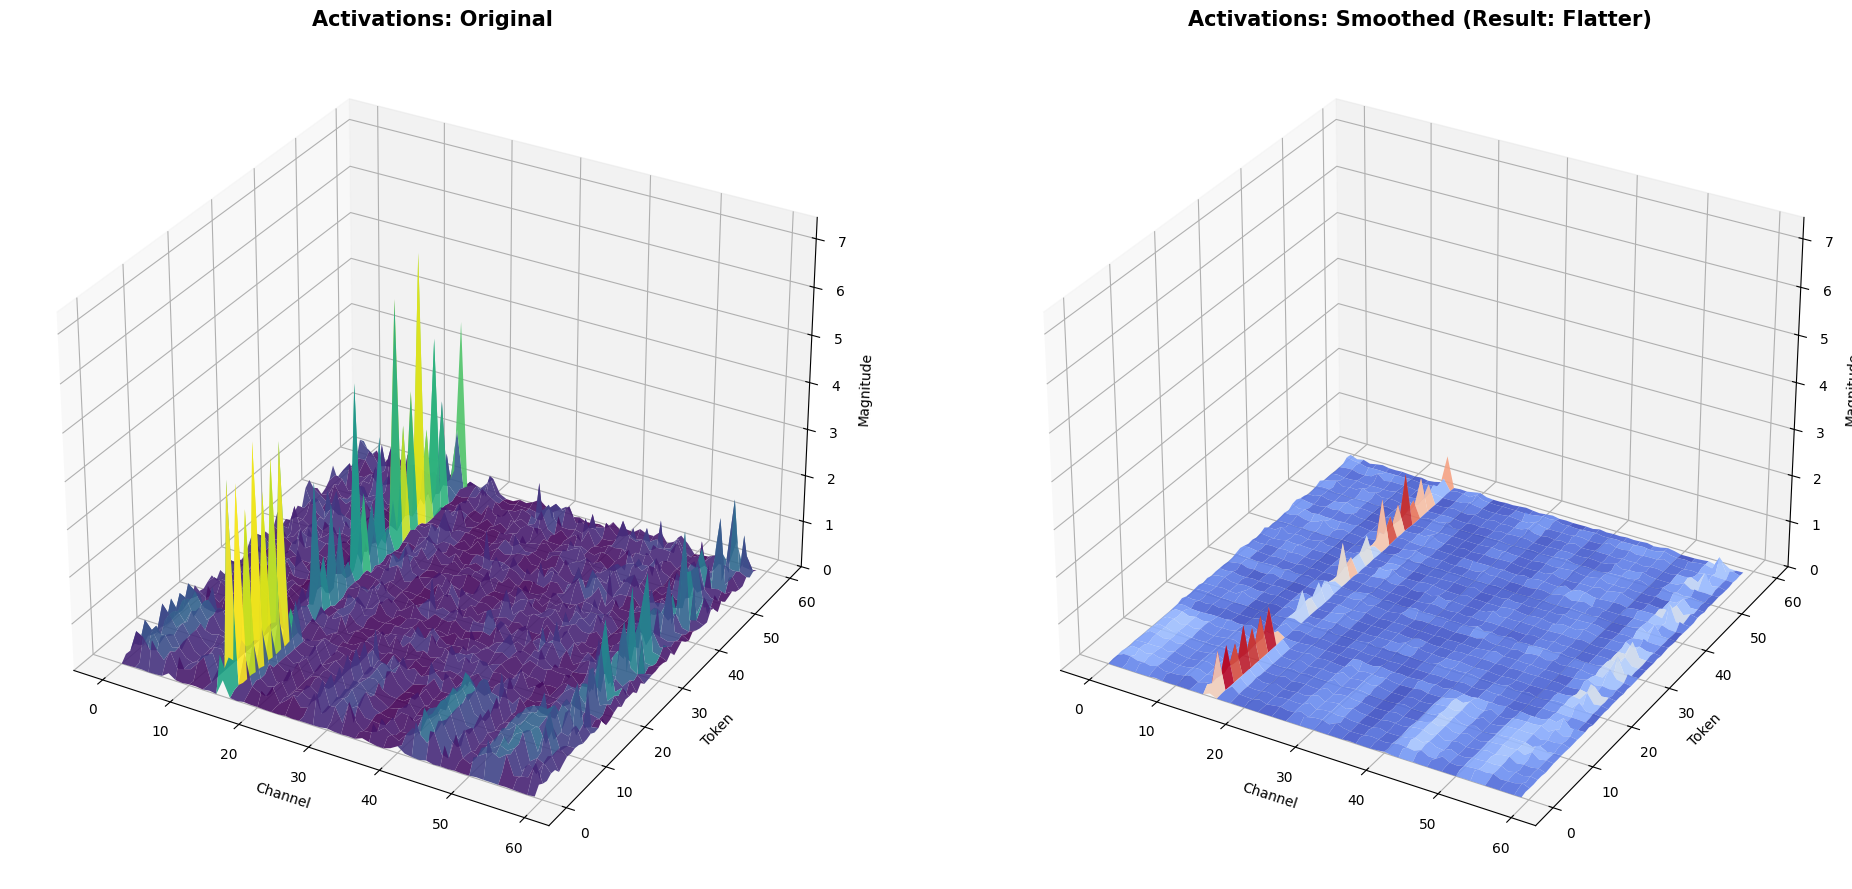

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch


def plot_smoothquant_effect_fixed_scale(data_before, data_after, title_prefix, xlabel='Channel', ylabel='Token', sample_rows=60, sample_cols=60):

    val_before = data_before.abs().detach().cpu().numpy()
    val_after = data_after.abs().detach().cpu().numpy()

    if val_before.ndim > 2: val_before = val_before[0]
    if val_after.ndim > 2: val_after = val_after[0]

    global_max = max(val_before.max(), val_after.max())
    z_limit = global_max * 1.1

    rows = min(val_before.shape[0], sample_rows)
    cols = min(val_before.shape[1], sample_cols)

    sub_before = val_before[:rows, :cols]
    sub_after = val_after[:rows, :cols]

    x = np.arange(cols)
    y = np.arange(rows)
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(20, 9))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, sub_before, cmap='viridis', edgecolor='none', alpha=0.9)
    ax1.set_title(f"{title_prefix}: Original", fontsize=15, fontweight='bold')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_zlabel('Magnitude')
    ax1.set_zlim(0, z_limit)
    ax1.view_init(elev=30, azim=-60)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, sub_after, cmap='coolwarm', edgecolor='none', alpha=0.9)

    if "Weight" in title_prefix:
        desc = "Smoothed (Result: Spikier)"
    else:
        desc = "Smoothed (Result: Flatter)"

    ax2.set_title(f"{title_prefix}: {desc}", fontsize=15, fontweight='bold')
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_zlabel('Magnitude')
    ax2.set_zlim(0, z_limit)
    ax2.view_init(elev=30, azim=-60)

    plt.tight_layout()
    plt.show()


# WEIGHTS: Original vs Smoothed
print(">>> PLOT: WEIGHT BEFORE/AFTER")

W_before = model.blocks[0].attn.qkv.weight.data
W_after  = smoothed_model.blocks[0].attn.qkv.weight.data

plot_smoothquant_effect_fixed_scale(
    W_before, W_after,
    "Weights",
    xlabel='Input Channel', ylabel='Output Channel'
)


# ACTIVATIONS: Original vs Smoothed
print("\n>>> PLOT: ACTIVATION BEFORE/AFTER")

# different from ActivationCollector
class DataCapturer:
    def __init__(self):
        self.data = None
        self.handle = None
    def hook_fn(self, m, i, o):
        self.data = i[0].detach().cpu() # Capture Activation
    def register(self, layer):
        self.handle = layer.register_forward_hook(self.hook_fn)
    def remove(self):
        if self.handle: self.handle.remove()


act_before = DataCapturer()
act_after = DataCapturer()

# Register
act_before.register(model.blocks[0].attn.qkv)
act_after.register(smoothed_model.blocks[0].attn.qkv)

device = next(model.parameters()).device
model.eval()
smoothed_model.eval()

with torch.no_grad():
    for img, _ in calibration_loader:
        img = img.to(device)
        model(img)          # Trigger act_before
        smoothed_model(img) # Trigger act_after
        break

act_before.remove()
act_after.remove()

if act_before.data is not None and act_after.data is not None:
    X_before = act_before.data[0]
    X_after  = act_after.data[0]

    print(f"Activation Before Max: {X_before.abs().max():.2f}")
    print(f"Activation After Max:  {X_after.abs().max():.2f}")
    print("(You should see the After Max is significantly smaller)")

    plot_smoothquant_effect_fixed_scale(
        X_before, X_after,
        "Activations",
        xlabel='Channel', ylabel='Token'
    )
else:
    print("Error: Failed to capture data.")
